# Wedgex

This is intended to be a usable version of the wedgex model code


## Import modules

In [199]:
import string
import itertools
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

## Define functions

In [200]:
def analytical_solution_particle_depth(t, x0, alpha, beta, L, vc, vd):
    
    v = vc / L
    
    x = (x0 + vd / v) * np.exp(v * t) - vd/v
    #$$x = \left( x_0 - \dfrac{v_d}{v} \right) e^{v t} - \dfrac{v_d}{v}$$
    
    C5 = -2 - (beta / (alpha - beta))
    #$$C_5 = (-2 - \dfrac{\beta}{\alpha - \beta})$$
    
    dc = alpha * x0 - beta * x0 * np.exp(v*t) - (alpha - beta) * x0 * np.exp(C5 * v * t)
    
    #$$d_c =  \alpha x_0 - \beta x_0 e^{v t} - \left(\alpha - \beta \right) x_0 e^{C_5 v t}$$

    dd = -beta * vd * t
    
    d = dc + dd
    
    y = alpha * x0 - d
    
    return x, d

## Set up model parameters

In [201]:
# compressional velocity
vc = -50e3 / 50e6

# transport velocity
vd = -50e3 / 50e6

# lenght of wedge
L = 200e3

# slope of topography (m/m)
alpha = 0.05

# slope of bottom of wedge (m/m)
beta = -0.1

# disctance between surface points (m)
x_interval = 1e4

# number of rows in the orogenic wedge. Used for figures only, no function in the actual model
n_rows = 100

# modelled timespan (years)
max_time = 1e8

# timestep size (years)
dt = 1e4

# name of file with thermochron data
thermochron_data_file = 'data/thermochron_data.csv'

# filename for file with modelled ages thermochron samples
thermochron_output_file = 'data/modelled_thermochron_data.csv'

# file with modelled ages vs distance
thermochron_profile_file = 'data/modelled_thermochron_profiles.csv'

# names of thermochronometers, should match the names in your input file
thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT']

# resetting temperatures
resetting_temperatures = [70.0, 110.0, 120.0, 200.0]

# geothermal gradient, used to convert resetting temp to depth (degr. C/m)
geothermal_gradient = 0.03 

# surface temperature at sea lvl (degr. C)
surface_temperature_sea_lvl = 10.0

# adiabatic lapse rate (C/m), used to correct surface temperature for elevation
lapse_rate = 6 / 1e3

# some figure options
fig_output_file = 'fig/model_output_figure.pdf'
thermochron_markers = ['o', 'd', 's', '^']
thermochron_colors = ['blue', 'orange', 'red', 'black']

## Parameters for particle position over time

In [202]:
# x-coordinates of starting points:
x0s = np.arange(0, L + x_interval, x_interval)

# timesteps (years)
t = np.arange(0, -max_time - dt, -dt)

print('particle starting points (m from tip of wedge):\n', x0s)

print('timesteps (yr):\n', t / 1e6)

particle starting points (m from tip of wedge):
 [     0.  10000.  20000.  30000.  40000.  50000.  60000.  70000.  80000.
  90000. 100000. 110000. 120000. 130000. 140000. 150000. 160000. 170000.
 180000. 190000. 200000.]
timesteps (yr):
 [ 0.000e+00 -1.000e-02 -2.000e-02 ... -9.998e+01 -9.999e+01 -1.000e+02]


## Load thermochron data

In [203]:
df = pd.read_csv(thermochron_data_file)

## Set up geometry of wedge

In [204]:
xcoords = np.linspace(0, L, 101)
y_top = xcoords * alpha
y_bottom = xcoords * beta

H = y_top.max() - y_bottom.min()

print('with the chosen slopes of land surface and wedge bottom/detachment the max height of '
      'the wedge is : ', H / 1e3, ' km')

ys = np.zeros((len(xcoords), n_rows))
xs = np.zeros_like(ys)
ybs = np.zeros_like(ys)

for i in range(len(xcoords)):
    ys[i, :] = np.linspace(y_bottom[i], y_top[i], n_rows)
    xs[i, :] = xcoords[i]
    ybs[i, :] = y_bottom[i]

with the chosen slopes of land surface and wedge bottom/detachment the max height of the wedge is :  30.0  km


## Run model for regular spacing of surface samples for figure

In [218]:
# np.array([y_position_over_time_correct_v2(t, x0, alpha, beta, vc, L) for x0 in x0s])

xdp = np.array([analytical_solution_particle_depth(t, x0, alpha, beta, L, vc, vd) for x0 in x0s])

xp, dp = xdp[:, 0], xdp[:, 1]

y0s = x0s * alpha

yp = np.array([y0i - dpi for y0i, dpi in zip(y0s, dp)])

## Find age vs distance for each thermochronometer

In [206]:
#target_depths = [2000.0, 4000.0]
y0s = x0s * alpha
sT = surface_temperature_sea_lvl - lapse_rate * y0s

modelled_ages_th = np.zeros((len(thermochron_systems), x0s.shape[0]))

for i, thc, rt in zip(itertools.count(), thermochron_systems, resetting_temperatures):
    rds =  (rt - sT) / geothermal_gradient

    for j, rd in enumerate(rds):
        age_int = np.interp(rd, dp[j], t)
        modelled_ages_th[i, j] = age_int

## Calculate resetting depth for samples

In [207]:
#thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT']
#resetting_temperatures = [70.0, 110.0, 120.0, 200.0]
#geothermal_gradient = 0.03 
#surface_temperature_sea_lvl = 10.0
#lapse_rate = 6 / 1e3

df['resetting_temp'] = np.nan

for thc, rt in zip(thermochron_systems, resetting_temperatures):
    
    ix = df['thermochronometer'] == thc 
    df.loc[ix, 'resetting_temp'] = rt
    
df['surface_T'] = surface_temperature_sea_lvl - lapse_rate * df['elevation']
df['resetting_depth'] = (df['resetting_temp'] - df['surface_T']) / geothermal_gradient

df.head()

,distance,elevation,age,thermochronometer,resetting_temp,surface_T,resetting_depth
0,25,500,20,AHe,70.0,7.0,2100.0
1,50,1000,15,AHe,70.0,4.0,2200.0
2,100,1500,10,AHe,70.0,1.0,2300.0


### Run model at exact location of surface samples

In [208]:
x0_samples = df['distance'].values * 1e3

xd_samples = np.array([analytical_solution_particle_depth(t, x0, alpha, beta, L, vc, vd) for x0 in x0_samples])

x_samples, d_samples = xd_samples[:, 0], xd_samples[:, 1]

y0_samples = x0_samples * alpha

y_samples = np.array([y0i - dpi for y0i, dpi in zip(y0_samples, d_samples)])

## Interpolate the modelled ages from the

In [209]:

target_depths_samples = df['resetting_depth'].values

n_samples = len(df)

modelled_age_samples = np.zeros((n_samples))

for j, td in zip(list(range(n_samples)), target_depths_samples):
    age_int = np.interp(td, d_samples[j], t)
    modelled_age_samples[j] = age_int

df['modelled_age'] = -modelled_age_samples / 1e6

df.head()

,distance,elevation,age,thermochronometer,resetting_temp,surface_T,resetting_depth,modelled_age
0,25,500,20,AHe,70.0,7.0,2100.0,15.355894
1,50,1000,15,AHe,70.0,4.0,2200.0,12.661418
2,100,1500,10,AHe,70.0,1.0,2300.0,9.268595


## Compare modelled and measured depth vs t data

In [210]:
from sklearn.metrics import r2_score

R2 = r2_score(df['age'], df['modelled_age'])

df['R2 for all samples combined'] = R2

df.head()

,distance,elevation,age,thermochronometer,resetting_temp,surface_T,resetting_depth,modelled_age,R2 for all samples combined
0,25,500,20,AHe,70.0,7.0,2100.0,15.355894,0.448567
1,50,1000,15,AHe,70.0,4.0,2200.0,12.661418,0.448567
2,100,1500,10,AHe,70.0,1.0,2300.0,9.268595,0.448567


## Make a figure of the results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


saving figure as fig/model_output_figure.pdf


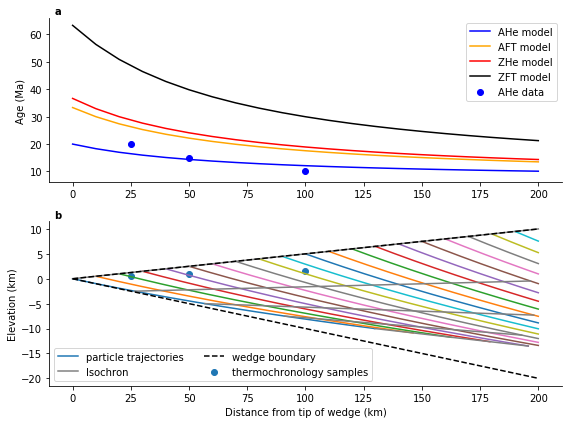

In [217]:
target_ts = [5e6, 10e6, 50e6, 100e6]

xpi, ypi = xp, yp
dpi = dp

fig, axs = pl.subplots(2, 1, figsize=(8, 6))


############################
# panel with time at depth=x
############################
for i, thc, c in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    axs[0].plot(x0s / 1e3, -modelled_ages_th[i] / 1e6, label='%s model' % thc, color=c)

    
for thc, m, c in zip(thermochron_systems, thermochron_markers, thermochron_colors):
    
    ix = df['thermochronometer'] == thc
    
    if np.any(ix) == True:
        axs[0].scatter(df.loc[ix, 'distance'], df.loc[ix, 'age'], label='%s data' % thc, color=c, marker=m)

axs[0].set_ylabel('Age (Ma)')

axs[0].legend()

#######################
# particle trajectories
#######################

ax = axs[-1]

ind = xpi > L
xpi[ind] = np.nan
ypi[ind] = np.nan

for xl, yl in zip(xpi, ypi):
    leg_traj, = ax.plot(xl / 1e3, yl / 1e3)

nt = xpi.shape[1]

isochron_ts = np.linspace(0, nt - 1, 5).astype(int)

for nti in isochron_ts:
    #leg_ts =  ax.scatter(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, s=20, color='black')
    leg_tsl, =  ax.plot(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, color='gray', ls='-')
    pass

leg_s = ax.scatter(df['distance'], df['elevation'] / 1e3, label='thermochron samples')

leg_bnd, = ax.plot(xcoords / 1e3, y_top / 1e3, color='black', ls='--', lw=1.5)
ax.plot(xcoords / 1e3, y_bottom / 1e3, color='black', ls='--', lw=1.5)

ax.set_xlabel('Distance from tip of wedge (km)')
ax.set_ylabel('Elevation (km)')

#ax.set_aspect('equal')

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.01, 1.01, string.ascii_lowercase[i], 
            weight='bold', transform=ax.transAxes, 
               ha='left', va='bottom', fontsize='medium')
    
axs[-1].legend([leg_traj, leg_tsl, leg_bnd, leg_s], 
          ['particle trajectories', 'Isochron', 'wedge boundary', 'thermochronology samples'], 
          loc='lower left', ncol=2)

fig.tight_layout()

print('saving figure as %s' % fig_output_file)
fig.savefig(fig_output_file)


## Save the file with the modelled ages

In [215]:
df['L'] = L
df['alpha'] = alpha
df['beta'] = beta
df['vd'] = vd
df['vc'] = vc
df['geothermal_gradient'] = geothermal_gradient

print('saving modelled ages thermochron samples to %s' % thermochron_output_file)
df.to_csv(thermochron_output_file)

saving modelled ages thermochron samples to data/modelled_thermochron_data.csv


## Save modelled themrochron distance vs age profiles

In [216]:
cols = thermochron_systems
index = x0s

dp = pd.DataFrame(index=index, columns=cols)

for i, col in enumerate(cols):
    dp[col] = - modelled_ages_th[i] / 1e6
    
dp['L'] = L
dp['alpha'] = alpha
dp['beta'] = beta
dp['vd'] = vd
dp['vc'] = vc
dp['geothermal_gradient'] = geothermal_gradient

print('saving modelled thermochron profiles as %s' % thermochron_profile_file)
dp.to_csv(thermochron_profile_file, index_label='distance')

saving modelled thermochron profiles as data/modelled_thermochron_profiles.csv
